## Fake Review Detector

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

import pickle


In [2]:
try:
    df = pd.read_csv("fake reviews dataset.csv")
except UnicodeDecodeError:
    df = pd.read_csv("fake reviews dataset.csv", encoding="latin-1")

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [4]:
expected = ['category', 'rating', 'label', 'text_']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. Found: {list(df.columns)}")

df = df[expected].copy()

df['text_'] = df['text_'].astype(str)
df['label'] = df['label'].astype(str).str.strip()

df['label'].value_counts()

label
CG    20216
OR    20216
Name: count, dtype: int64

In [5]:
df.isna().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [6]:
df.rename(columns={'label': 'target', 'text_': 'text'}, inplace=True)
df['target'].value_counts()


target
CG    20216
OR    20216
Name: count, dtype: int64

In [7]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,40432.000000,40432.000000,40432.000000
mean,351.271963,76.671003,5.276143
std,369.813570,79.230384,4.914112
min,24.000000,2.000000,1.000000
25%,107.000000,24.000000,2.000000
50%,198.000000,44.000000,3.000000
75%,439.000000,96.000000,6.000000
max,2827.000000,510.000000,133.000000


In [8]:
df[df['target']=='OR'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,20216.000000,20216.000000,20216.000000
mean,396.970419,84.111249,5.098585
std,418.428047,87.131524,4.481774
min,28.000000,7.000000,1.000000
25%,121.000000,26.000000,2.000000
50%,224.000000,48.000000,4.000000
75%,498.000000,106.000000,6.000000
max,2827.000000,510.000000,51.000000


In [9]:
df[df['target']=='CG'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,20216.000000,20216.000000,20216.000000
mean,305.573506,69.230758,5.453700
std,307.037430,69.660575,5.305547
min,24.000000,2.000000,1.000000
25%,96.000000,21.000000,2.000000
50%,174.000000,39.000000,3.000000
75%,383.000000,87.000000,7.000000
max,1717.000000,344.000000,133.000000


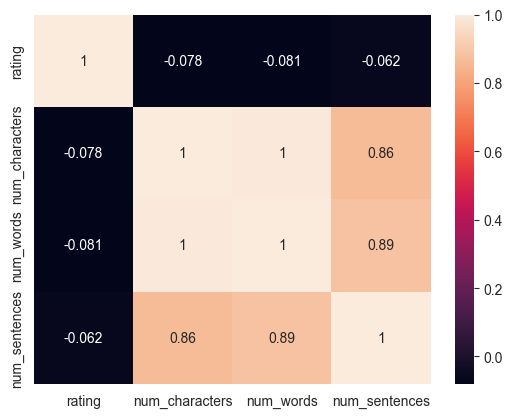

In [10]:
# Correlation heatmap on numeric columns only
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()


In [11]:
ps = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))
PUNCT = set(string.punctuation)

def transform_text(text):
    text = str(text).lower()
    tokens = nltk.word_tokenize(text)

    y = []
    for w in tokens:
        if w.isalnum() and (w not in STOPWORDS) and (w not in PUNCT):
            y.append(ps.stem(w))

    return " ".join(y)

df["transformed_text"] = df["text"].astype(str).apply(transform_text)
df[['text','transformed_text']].head()

,text,transformed_text
0,"Love this! Well made, sturdy, and very comfor...",love well made sturdi comfort love pretti
1,"love it, a great upgrade from the original. I...",love great upgrad origin mine coupl year
2,This pillow saved my back. I love the look and...,pillow save back love look feel pillow
3,"Missing information on how to use it, but it i...",miss inform use great product price
4,Very nice set. Good quality. We have had the s...,nice set good qualiti set two month


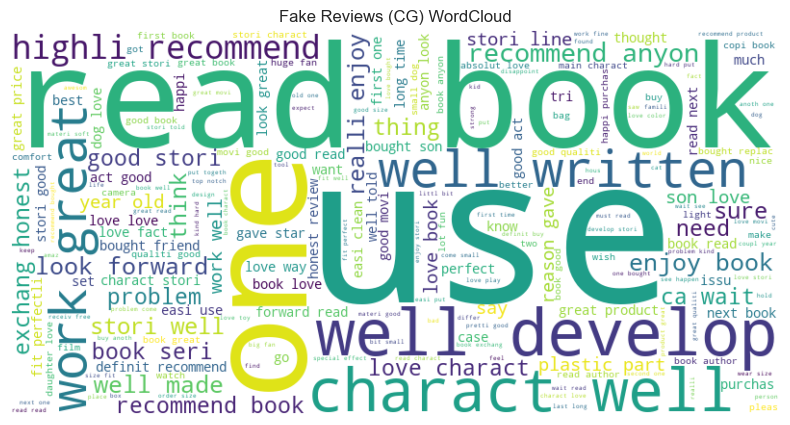

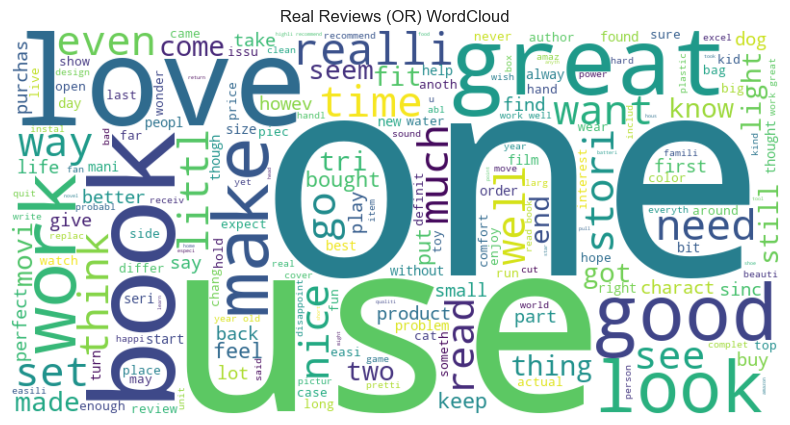

In [12]:
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white")

text_fake = df[df['target']=='CG']['transformed_text'].dropna().astype(str).str.cat(sep=" ")
text_real = df[df['target']=='OR']['transformed_text'].dropna().astype(str).str.cat(sep=" ")

plt.figure(figsize=(10,5))
plt.imshow(wc.generate(text_fake), interpolation="bilinear")
plt.axis("off")
plt.title("Fake Reviews (CG) WordCloud")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wc.generate(text_real), interpolation="bilinear")
plt.axis("off")
plt.title("Real Reviews (OR) WordCloud")
plt.show()

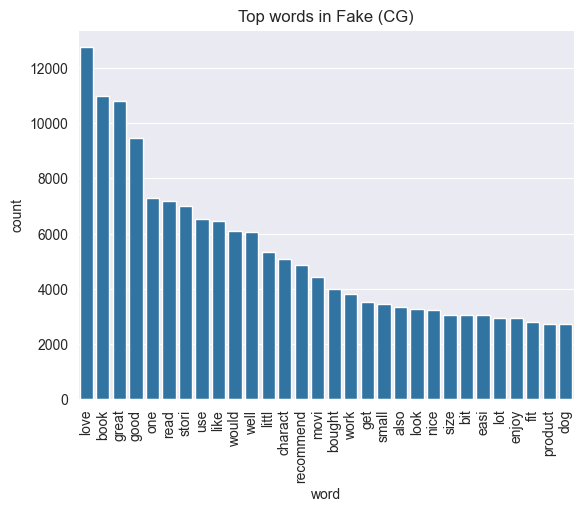

In [13]:
from collections import Counter

fake_corpus = []
for msg in df[df['target']=='CG']['transformed_text'].dropna().astype(str).tolist():
    fake_corpus.extend(msg.split())

fake_df = pd.DataFrame(Counter(fake_corpus).most_common(30), columns=['word','count'])

sns.barplot(data=fake_df, x='word', y='count')
plt.xticks(rotation=90)
plt.title("Top words in Fake (CG)")
plt.show()

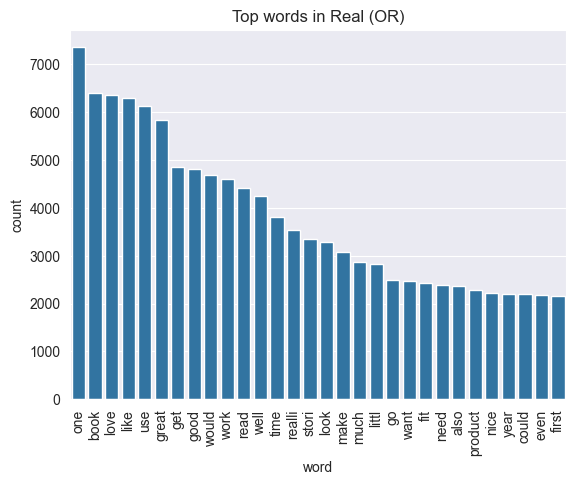

In [14]:
real_corpus = []
for msg in df[df['target']=='OR']['transformed_text'].dropna().astype(str).tolist():
    real_corpus.extend(msg.split())

real_df = pd.DataFrame(Counter(real_corpus).most_common(30), columns=['word','count'])

sns.barplot(data=real_df, x='word', y='count')
plt.xticks(rotation=90)
plt.title("Top words in Real (OR)")
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Word + character TF-IDF (strong baseline for fake reviews)
word_tfidf = TfidfVectorizer(max_features=3000)
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=5, max_features=3000)

tfidf = FeatureUnion([
    ('word', word_tfidf),
    ('char', char_tfidf)
])


In [16]:
from scipy.sparse import hstack, csr_matrix

# Text features (Word+Char TF-IDF) -> sparse matrix
X_text = tfidf.fit_transform(df['transformed_text'])

# Additional engineered numeric features (keeps ALL existing numeric features)
X_num = csr_matrix(df[['num_characters','num_words','num_sentences']].values)

# Combine TF-IDF + numeric features (still sparse, memory-friendly)
X = hstack([X_text, X_num])

y = df['target'].values


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)


In [18]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


In [19]:
mnb = MultinomialNB()
bnb = BernoulliNB()

# Strong classical baseline for TF-IDF text
lrc = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=2000)

# Linear SVM is usually excellent for TF-IDF text and much faster than kernel SVC
lsvc = LinearSVC()


In [20]:
# Logistic Regression
lrc.fit(X_train, y_train)
y_pred_lr = lrc.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision (CG as positive):", precision_score(y_test, y_pred_lr, pos_label='CG', zero_division=0))
print("Recall (CG as positive):", recall_score(y_test, y_pred_lr, pos_label='CG', zero_division=0))
print("F1 (CG as positive):", f1_score(y_test, y_pred_lr, pos_label='CG', zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression
Accuracy: 0.8858662050204031
Precision (CG as positive): 0.8797761012411779
Recall (CG as positive): 0.8939169139465876
F1 (CG as positive): 0.8867901385992886
Confusion Matrix:
 [[3615  429]
 [ 494 3549]]


In [21]:
# Linear SVM
lsvc.fit(X_train, y_train)
y_pred_svm = lsvc.predict(X_test)

print("LinearSVC")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision (CG as positive):", precision_score(y_test, y_pred_svm, pos_label='CG', zero_division=0))
print("Recall (CG as positive):", recall_score(y_test, y_pred_svm, pos_label='CG', zero_division=0))
print("F1 (CG as positive):", f1_score(y_test, y_pred_svm, pos_label='CG', zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


LinearSVC
Accuracy: 0.8895758624953629
Precision (CG as positive): 0.8839873263465757
Recall (CG as positive): 0.8968842729970327
F1 (CG as positive): 0.8903891002823126
Confusion Matrix:
 [[3627  417]
 [ 476 3567]]


In [22]:
# Multinomial Naive Bayes
mnb.fit(X_train, y_train)
y_pred_nb = mnb.predict(X_test)

print("MultinomialNB")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision (CG as positive):", precision_score(y_test, y_pred_nb, pos_label='CG', zero_division=0))
print("Recall (CG as positive):", recall_score(y_test, y_pred_nb, pos_label='CG', zero_division=0))
print("F1 (CG as positive):", f1_score(y_test, y_pred_nb, pos_label='CG', zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


MultinomialNB
Accuracy: 0.7980709781130209
Precision (CG as positive): 0.7744138402003187
Recall (CG as positive): 0.841246290801187
F1 (CG as positive): 0.8064477894986369
Confusion Matrix:
 [[3402  642]
 [ 991 3052]]


In [23]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', max_iter=1000)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [24]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [25]:
from sklearn.preprocessing import LabelEncoder


def train_classifier(clf, X_train, y_train, X_test, y_test):
    if clf.__class__.__name__ == "XGBClassifier":
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)

        clf.fit(X_train, y_train_enc)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test_enc, y_pred)
        precision = precision_score(y_test_enc, y_pred)
        return accuracy, precision

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='CG')
    return accuracy, precision

In [26]:
train_classifier(svc,X_train,y_train,X_test,y_test)

C:\Users\shaki\Documents\JupyterProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


(0.4999381723754173, 0.0)

In [27]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

C:\Users\shaki\Documents\JupyterProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


For  SVC
Accuracy -  0.4999381723754173
Precision -  0.0
For  KN
Accuracy -  0.6773834549276617
Precision -  0.6726004330045706
For  NB
Accuracy -  0.7980709781130209
Precision -  0.7744138402003187
For  DT
Accuracy -  0.6908618770866823
Precision -  0.6741091565178169
For  LR
Accuracy -  0.8856188945220724
Precision -  0.879532733025067
For  RF
Accuracy -  0.8496352170149623
Precision -  0.8510427010923535
For  AdaBoost
Accuracy -  0.7670335105725238
Precision -  0.7575107296137339
For  BgC
Accuracy -  0.8228020279460863
Precision -  0.8205254112447827
For  ETC
Accuracy -  0.8465438357858291
Precision -  0.851693851944793
For  GBDT
Accuracy -  0.8031408433287993
Precision -  0.7818390804597701
For  xgb
Accuracy -  0.8715221961172251
Precision -  0.868860510805501


In [28]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
4,LR,0.885619,0.879533
10,xgb,0.871522,0.868861
8,ETC,0.846544,0.851694
5,RF,0.849635,0.851043
7,BgC,0.822802,0.820525
9,GBDT,0.803141,0.781839
2,NB,0.798071,0.774414
6,AdaBoost,0.767034,0.757511
3,DT,0.690862,0.674109
1,KN,0.677383,0.672600


In [29]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=performance_df, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

ValueError: Could not interpret value `value` for `y`. An entry with this name does not appear in `data`.

In [27]:
import pickle
from sklearn.metrics import f1_score

# Pick best among LR, LinearSVC, and MultinomialNB by F1 (CG is positive)
f1_lr = f1_score(y_test, y_pred_lr, pos_label='CG', zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, pos_label='CG', zero_division=0)
f1_nb = f1_score(y_test, y_pred_nb, pos_label='CG', zero_division=0)

scores = {'LogisticRegression': f1_lr, 'LinearSVC': f1_svm, 'MultinomialNB': f1_nb}
best_name = max(scores, key=scores.get)

best_model = {'LogisticRegression': lrc, 'LinearSVC': lsvc, 'MultinomialNB': mnb}[best_name]

print("F1 scores:", scores)
print("Saving best model:", best_name)

# Save vectorizer (FeatureUnion) + model in the same filenames your Streamlit app expects
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(best_model, open('model.pkl', 'wb'))

print("Saved vectorizer.pkl and model.pkl")


Saved vectorizer.pkl and model.pkl
